In [19]:
###############################
# Ayoub Sikouky
# SID:1719909
# Edit Date: 05/04/2022
# GitHub Repo:
# https://github.com/AYSIK0/Kaggle_Intel-MobileODT-Cervical-Cancer-Screening
###############################
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, BatchNormalization, Dropout, Rescaling, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import seaborn as sns
import os
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Data Processing

#### 1.1 Handling directories

In [2]:
# Check if colab is used.
using_google_colab = "google.colab" in str(get_ipython())

DIR_PATH   = "intel-mobileodt-cervical-cancer-screening/"
## When Using Google Colab
if using_google_colab:
  from google.colab import drive
  drive.mount('/content/drive')
  colab_path = "/content/drive/MyDrive/ARU's Master/Neural computing and Deep Learning/Assignments/Kaggle Assignment/"

  COLAB_DIR_PATH = colab_path + DIR_PATH
  MODELS_PATH = colab_path + "Models/"
  CSV_FOLDER  = colab_path + "predictions_csv/"
  TRAIN_PATH  = os.path.join(COLAB_DIR_PATH, "train/train")
  TEST_STG1_PATH  = os.path.join(COLAB_DIR_PATH, "test/test")
  TEST_STG2_PATH  = os.path.join(COLAB_DIR_PATH, "test_stg2")

else:
#When Using Local Machine.
  MODELS_PATH = "Models/"
  CSV_FOLDER = "predictions_csv/"
  TRAIN_PATH = os.path.join(DIR_PATH, "train/train")
  TEST_STG1_PATH  = os.path.join(DIR_PATH, "test/test")
  TEST_STG2_PATH  = os.path.join(DIR_PATH, "test_stg2")

#### 1.2 Helper Functions

In [25]:
# Helper Functions

def get_imgs_paths(dirs, sort=True):
    """
    This functions will return a list of images's paths from 
    the directories supplied. The returned list can be sorted if the "sort=True".
    """
    dirs_list   = [] # List for the parent directories.
    fname_lists  = [] # List for all files in the parents directories.
    paths_lists = [] # This list will continue thr ordered list of files paths.
    
    # Check if the dirs is a list of paths.
    if isinstance(dirs, list):
        for d in dirs:
            dirs_list.append(d)
            # Getting all files inside the dierectory.
            tmp_list = [f.name for f in os.scandir(d) if f.is_file() and f.name.endswith(".jpg")]
            # Sort the files.
            if sort:
                tmp_list.sort(key=lambda x: int(x.split('.')[0]))
            fname_lists.append(tmp_list)
    else:
        dirs_list.append(dirs)
        tmp_list = [f.name for f in os.scandir(dirs) if f.is_file() and f.name.endswith(".jpg")]
        if sort:
            tmp_list.sort(key=lambda x: int(x.split('.')[0]))
        fname_lists.append(tmp_list)
    
    # Create the paths list which is will be ordered. 
    for i in range(len(dirs_list)):
        paths_lists.append([os.path.join(dirs_list[i], f) for f in fname_lists[i]])

    return paths_lists

def get_test_vald_ds(train_path, batch_size, img_size, split=0.2, seed=1710, 
                     shuffle=True, label_mode="categorical", 
                     interpolation="bicubic", normalise=False, norm_scale="zero_one"):
  """
  This function will create and optimise Training and Validation Dataset,
  it can also normalise them if needed.

  Parameters:

  train_path: The path for training images.
  batch_size: The number of images inside each batch. 
  img_size: The new image size.
  split: How much of the training data will be reserved to a validation
         Default=0.2 (80% Train, 20% Validation)

  seed: The seed use when dividing the train and validation datasets.
  shuffle: Wheter to shuffle the data or not. Default=True.
  label_mode: How the label will be mapped. Default="Categorical" 
              example: [0, 1, 0] where 1 is the correct label.

  interpolation: The method used to resise images. Default="Bicubic"
  normalise: If dataset need to be normalised. Default=False
  norm_scale: The range of the normalisation. Default="zero_one"
              "zero_one"=[0, 1] or "mone_one"=[-1, 1].
  """
  test_ds = image_dataset_from_directory(train_path, 
                                         labels="inferred", label_mode=label_mode, 
                                         color_mode="rgb", batch_size=batch_size,
                                         image_size=img_size, shuffle = shuffle, 
                                         seed=seed, validation_split=split, 
                                         subset="training", interpolation=interpolation)

  valid_ds = image_dataset_from_directory(train_path,
                                          labels="inferred", label_mode=label_mode,
                                          color_mode="rgb", batch_size=batch_size,
                                          image_size=img_size, shuffle=shuffle,
                                          seed=seed, validation_split=split,
                                          subset="validation", interpolation=interpolation)
  # Optimisation
  AUTOTUNE = tf.data.AUTOTUNE
  test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
  valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

  # Normalising the datasets if normalise==True.
  if normalise:
    if norm_scale == "zero_one":
      test_ds  = clip_normalise(test_ds, zero_one=True, mone_one=False)
      valid_ds = clip_normalise(valid_ds, zero_one=True, mone_one=False)
    elif norm_scale == "mone_one":
      test_ds  = clip_normalise(test_ds, zero_one=False, mone_one=True)
      valid_ds = clip_normalise(valid_ds, zero_one=False, mone_one=True)
    else:
      print("norm_scale can only be 'zero_one' or 'mone_one'")
      return

  return (test_ds, valid_ds)

def process_img(img_path, img_size, method="bicubic"):
  """
  This function is used to read image resize it and 
  change its type to float32.

  Parameters:
  img_path: The image Path.
  img_size: The new image size.
  method: The method used to resize the image.
  """
  img_string = tf.io.read_file(img_path)
  img = tf.image.decode_jpeg(img_string, channels=3)
  img = tf.image.resize(img, [img_size[0], img_size[1]], method)
  img = tf.cast(img, tf.float32)
  return img
    
def create_test_dataset(imgs_paths, method="bicubic", 
                        img_size=(256, 256), batch_size=32, 
                        normalise=False, norm_scale="zero_one"):
  """
  Creates Test datasets.

  Parameters:

  imgs_paths: Images paths used to create the dataset.
  method: The method used to resize the image.
  img_size: The new image size.
  batch_size: The number of images in each batch.
  normalise: If True normalise the data. Deafault = False.
  norm_scale: The range of the normalisation. Default="zero_one"
              "zero_one"=[0, 1] or "mone_one"=[-1, 1].
  """
  ds = tf.data.Dataset.from_tensor_slices(imgs_paths)
  ds = ds.map(lambda x: process_img(x, img_size=img_size, method=method))
  ds = ds.batch(batch_size)

  if normalise:
    if norm_scale == "zero_one":
      ds  = clip_normalise(ds, test_set=True, zero_one=True, mone_one=False)
    elif norm_scale == "mone_one":
      ds  = clip_normalise(ds, test_set=True, zero_one=False, mone_one=True)
    else:
      print("norm_scale can only be 'zero_one' or 'mone_one'")
      return
  return ds


def clip_normalise(dataset, test_set=False, zero_one=True, mone_one=False):
    """
    Takes datasets as input then it clips the images pixel 
    values to [0, 255], then normalise them either to [0, 1] or [-1, 1]

    Parameters:
    dataset:
    test_set:
    zero_one: if True scale images to [0, 1].
    mone_one: if True Scale images to [-1, 1].
    """
    if zero_one and mone_one:
      return print("Only one range can be True either [0-1] or [-1,1]!!")
    if zero_one:  
      normalise = Rescaling(1./255)
    elif mone_one:
      normalise = Rescaling(1./127.5, offset=-1)
    if not test_set:
      dataset = dataset.map(lambda x, y: (tf.clip_by_value(x, 0.0, 255.0), y))
      dataset = dataset.map(lambda x, y: (normalise(x), y))
    else:
      dataset = dataset.map(lambda x: tf.clip_by_value(x, 0.0, 255.0))
      dataset = dataset.map(lambda x: normalise(x))
    return dataset

def get_aug_dataset(ds, data_aug):
  """
  This function takes a dataset tha it return an augmneted version of it.

  Parameters:
  ds: The Dataset to be augmented.
  data_aug: The Model with the layers that will augment the data.
  """
  AUTOTUNE = tf.data.AUTOTUNE
  ds = ds.map(lambda x, y: (data_aug(x, training=True), y), 
              num_parallel_calls=AUTOTUNE)
  return ds.prefetch(buffer_size=AUTOTUNE)

def plot_metric(m_history, metric: str, val=True):
  """
  Plots the model metrics.

  Parameters:
  m_history = The model history.
  metric: The metric name to plot.
  val: If True plot the metrics for validation dataset. 
       Default=True.
  """
  train_metric = m_history.history[metric]
  if val:
    val_metric = m_history.history["val_"+metric]

  num_epochs = range(1, len(train_metric)+1)
  plt.plot(num_epochs, train_metric)
  if val:
    plt.plot(num_epochs, val_metric)
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  if val:
    plt.title(f"Train and Validation: {metric}")
    plt.legend(["Train", "Validation"], loc="best")
  else:
    plt.title(f"Train : {metric}")
    plt.legend(["Train"], loc="best")
  
  plt.show()

def plot_confusion_matrix(cf_matrix, labels, figsize=(10,6), xlabel=None, 
                          ylabel=None, cmap="Blues"):
  """
  This function will plot a Confusion Matrix.
  
  Parameters:

  cf_matrix: The confusion matrix.
  labels   : The classes names.
  figsize  : Figure size default=(10,6).
  xlabel   : Labels for x axis. 
  ylabel   : Labels for y axis. 
  cmap     : Color map used default="Blues". 
  """
  type_counts = [f"{v:0.0f}" for v in cf_matrix.flatten()]
  categories_percentage = [f"{v:.2%}" for v in cf_matrix.flatten()/np.sum(cf_matrix)]

  map_labels = [f"{tc}\n{cp}" for tc , cp in zip(type_counts, categories_percentage)]
  map_labels = np.asarray(map_labels).reshape(cf_matrix.shape[0],cf_matrix.shape[1])

  plt.figure(figsize=figsize)
  sns.heatmap(cf_matrix, fmt="",
              xticklabels=labels, yticklabels=labels, 
              annot=map_labels, cmap=cmap)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

def create_csv(file_name, predictions, header, imgs_path, csv_path):
  """
  This function will create the csv file from the 
  predictions generated by the model.
  
  Parameters:

  file_name: The name that will be given to the file.
  predictions: Numpy array that contains the model predictions.
  header: The header to use in CSV file.
  imgs_path: Used to get Images name form their path.
  csv_path: Path of the directory where the csv file will be saved.
  """
  # Make the directory for saving csv files.
  Path(csv_path).mkdir(parents=True, exist_ok=True)

  df = pd.DataFrame({header[0] : [img_name.split("/")[-1] for img_name in imgs_path],
                     header[1] : predictions[:, 0],
                     header[2] : predictions[:, 1],
                     header[3] : predictions[:, 2]})
  df = df.set_index(header[0])
  try:
    df.to_csv(csv_path+file_name)
    print("csv file was created and saved successfully.")
  except Exception as e:
    print(f"csv file wasn't saved beacuse of the error: {e}")

def get_test_values(preditctions, true_values_file, use_colab: bool):
  """
  This functions extract the test values and return them.

  Parameters:
  predictions: The predictions created by the model.
  true_values_file: File name with the true labels.
  use_colab: Wether Google Colab is used.
  """

  # Predictions
  test_pred_values = [np.argmax(pv) for pv in preditctions]

  # Ground Truth
  if use_colab: 
    test_true_df = pd.read_csv(COLAB_DIR_PATH+true_values_file)
  else:
    test_true_df = pd.read_csv(DIR_PATH+true_values_file)

  test_true_rows = test_true_df.apply(lambda r: (r.Type_1, r.Type_2, r.Type_3), axis=1)
  test_true_values = [np.argmax(tv) for tv in test_true_rows]

  return (test_true_values, test_pred_values)

#### 1.3 Data Analysis

In [4]:
# Train Images
train_paths = [f.path for f in os.scandir(TRAIN_PATH) if f.is_dir()]
train_img_lists = get_imgs_paths(train_paths, sort=True)
train_img_t1  = train_img_lists[0] 
train_img_t2  = train_img_lists[1]
train_img_t3  = train_img_lists[2]
train_imgs_all = train_img_t1 + train_img_t2 + train_img_t3

In [5]:
# Test Images
test_paths = [TEST_STG1_PATH, TEST_STG2_PATH]
test_img_lists = get_imgs_paths(test_paths, sort=True)
test_imgs_stg1 = test_img_lists[0]
test_imgs_stg2 = test_img_lists[1]
test_imgs_all  =  test_imgs_stg1 + test_imgs_stg2

In [6]:
all_train_imgs_df = pd.DataFrame({"image_path" : train_imgs_all})
all_train_imgs_df["name"] = all_train_imgs_df.apply(lambda r: 
                                                        r.image_path.split("/")[-1], axis=1)
all_train_imgs_df["type"] = all_train_imgs_df.apply(lambda r: 
                                                        r.image_path.split("/")[-2], axis=1)

all_train_imgs_df

,image_path,name,type
0,intel-mobileodt-cervical-cancer-screening/trai...,0.jpg,Type_1
1,intel-mobileodt-cervical-cancer-screening/trai...,7.jpg,Type_1
2,intel-mobileodt-cervical-cancer-screening/trai...,10.jpg,Type_1
3,intel-mobileodt-cervical-cancer-screening/trai...,12.jpg,Type_1
4,intel-mobileodt-cervical-cancer-screening/trai...,13.jpg,Type_1
...,...,...,...
1475,intel-mobileodt-cervical-cancer-screening/trai...,1469.jpg,Type_3
1476,intel-mobileodt-cervical-cancer-screening/trai...,1470.jpg,Type_3
1477,intel-mobileodt-cervical-cancer-screening/trai...,1475.jpg,Type_3
1478,intel-mobileodt-cervical-cancer-screening/trai...,1477.jpg,Type_3


Train Images:
Total Number of Train Images: 1480
Number of Type 1 Images: 249
Number of Type 2 Images: 781
Number of Type 3 Images: 450

Test Images:
Total Number of Test Images: 4018
Number of Stage 1 Test Images: 512
Number of Stage 2 Test Images: 3506

Max Image Size: (4128, 3096)
Min Image Size: (480, 640)



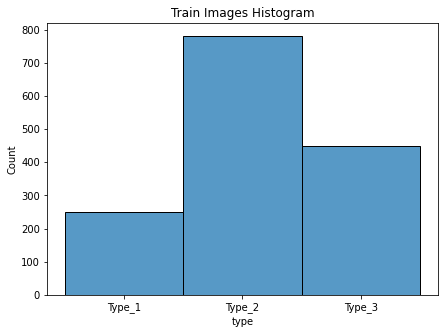

In [7]:
plt.figure(figsize=(7, 5))
sns.histplot(all_train_imgs_df.type).set_title("Train Images Histogram")
print("Train Images:")
print(f"Total Number of Train Images: {all_train_imgs_df.shape[0]}")
print(f"Number of Type 1 Images: {len(train_img_t1)}")
print(f"Number of Type 2 Images: {len(train_img_t2)}")
print(f"Number of Type 3 Images: {len(train_img_t3)}")
print("\nTest Images:")
print(f"Total Number of Test Images: {len(test_imgs_all)}")
print(f"Number of Stage 1 Test Images: {len(test_imgs_stg1)}")
print(f"Number of Stage 2 Test Images: {len(test_imgs_stg2)}\n")

# This code is slow to run in colab.
# max_img_size = max(Image.open(f, 'r').size for f in all_train_imgs_df.image_path)
# min_img_size = min(Image.open(f, 'r').size for f in all_train_imgs_df.image_path)
max_img_size = (4128, 3096)
min_img_size = (480, 640)
print(f"Max Image Size: {max_img_size}")
print(f"Min Image Size: {min_img_size}\n")

#### 1.4 Data Processing

In [8]:
BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)

# This will be used for Data augmentation.
data_aug = Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomRotation(0.2),
])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-04-05 00:13:20.910070: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-05 00:13:20.910489: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


These datasets only used for the first model, other models use Augmented Dataset
for training.

In [9]:
train_dataset, val_dataset = get_test_vald_ds(TRAIN_PATH, BATCH_SIZE, IMAGE_SIZE,
                                              normalise=True, norm_scale="zero_one")

Found 1480 files belonging to 3 classes.
Using 1184 files for training.
Found 1480 files belonging to 3 classes.
Using 296 files for validation.


In [10]:
test_STG1_dataset = create_test_dataset(test_imgs_stg1, method="bicubic", 
                                        img_size=IMAGE_SIZE, batch_size=BATCH_SIZE, 
                                        normalise=True, norm_scale="zero_one")
test_STG2_dataset = create_test_dataset(test_imgs_stg2, method="bicubic", 
                                        img_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                                        normalise=True, norm_scale="zero_one")
test_dataset_all  = test_STG1_dataset.concatenate(test_STG2_dataset)

### 2 Models

#### 2.1 Base Models

In [11]:
epochs = 30
NUM_CLASSES = 3
CLASS_NAMES = ["Type_1", "Type_2", "Type_3"]

# The header will be used to create the CSV files.
header = ["image_name", "Type_1", "Type_2", "Type_3"] 

In [10]:
# CallBacks
my_callbacks = [
                EarlyStopping(monitor="loss", patience=7, restore_best_weights=True),
                ]

##### 2.1.1 Without Data Augmentation

In [ ]:
# Basic Model to esablish a baseline.
model = Sequential([

    Conv2D(16, 3, padding="same", input_shape=(256, 256, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(32, 3, padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, 3, padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, 3, padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(256, 3, padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(),

    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation="softmax")
])

In [ ]:
model.compile(optimizer="adam",
              loss = "categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                        

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=my_callbacks)

Epoch 1/30
37/37 [==============================] - 385s 8s/step - loss: 3.8416 - accuracy: 0.4299 - val_loss: 1.1581 - val_accuracy: 0.5203
Epoch 2/30
37/37 [==============================] - 5s 130ms/step - loss: 2.5589 - accuracy: 0.4079 - val_loss: 1.5927 - val_accuracy: 0.5203
Epoch 3/30
37/37 [==============================] - 5s 129ms/step - loss: 1.8739 - accuracy: 0.4079 - val_loss: 1.0955 - val_accuracy: 0.3412
Epoch 4/30
37/37 [==============================] - 5s 128ms/step - loss: 1.3838 - accuracy: 0.4299 - val_loss: 1.0309 - val_accuracy: 0.5203
Epoch 5/30
37/37 [==============================] - 5s 129ms/step - loss: 1.1653 - accuracy: 0.4628 - val_loss: 1.0243 - val_accuracy: 0.5068
Epoch 6/30
37/37 [==============================] - 5s 129ms/step - loss: 1.1039 - accuracy: 0.4873 - val_loss: 1.0047 - val_accuracy: 0.5068
Epoch 7/30
37/37 [==============================] - 5s 128ms/step - loss: 1.0640 - accuracy: 0.4966 - val_loss: 1.0189 - val_accuracy: 0.4764
Epoch 8

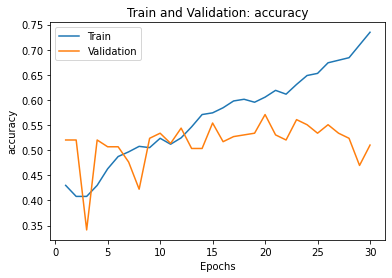

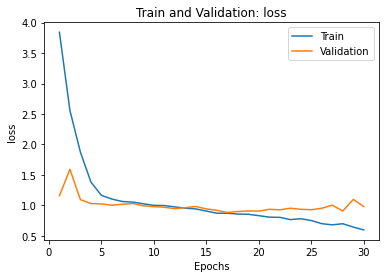

In [ ]:
# Plotting Accuracy.
plot_metric(history, "accuracy")

# Plotting Losses.
plot_metric(history, "loss")

In [ ]:
# Save the model.
model.save(MODELS_PATH+"base_model_1.h5")

In [12]:
# Load the first tarined base model. (Uncomment to use)
model_trained = load_model(MODELS_PATH+"base_model_1.h5")

In [13]:
# Uncomment If needed.
#test_predictions = model.predict(test_STG1_dataset, verbose=1)
test_predictions = model_trained.predict(test_STG1_dataset, verbose=1)

2022-04-05 00:13:55.876530: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-05 00:13:55.997674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 7s 432ms/step


In [14]:
test_true_values, test_predictions_values = get_test_values(test_predictions, 
                                                            "solution_stg1_release.csv", 
                                                            using_google_colab)

In [15]:
clas_report = classification_report(test_true_values, test_predictions_values, target_names=CLASS_NAMES, zero_division="warn")
print(clas_report)

              precision    recall  f1-score   support

      Type_1       0.29      0.20      0.23        87
      Type_2       0.55      0.70      0.62       265
      Type_3       0.61      0.43      0.50       160

    accuracy                           0.53       512
   macro avg       0.48      0.44      0.45       512
weighted avg       0.52      0.53      0.52       512



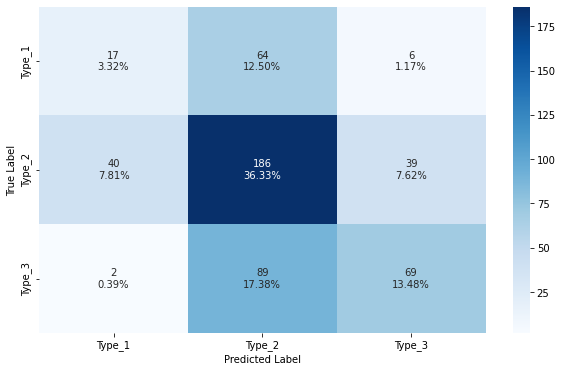

In [16]:
conf_matrix = confusion_matrix(test_true_values, test_predictions_values)
plot_confusion_matrix(conf_matrix, CLASS_NAMES, 
                      xlabel="Predicted Label", ylabel="True Label", 
                      cmap="Blues") 


In [ ]:
# predicting the labels for test Stage 1 and 2 (4018 images).

# Uncomment If needed.
#test_predictions = model.predict(test_dataset_all, verbose=1)
test_predictions = model_trained.predict(test_dataset_all, verbose=1)

126/126 [==============================] - 843s 7s/step


In [28]:
# Creating the csv for the model predictions, this is one the CSV files  
# that will be submitted to kaggle.
create_csv("base_model_1.csv", test_predictions, header, test_imgs_all, CSV_FOLDER)

csv file was created and saved successfully.


##### 2.1.2 With Data Augmentation

In [ ]:
# only The train Dataset will be augmented.
train_dataset = get_aug_dataset(train_dataset, data_aug)

In [ ]:
# Basic Model to esablish a baseline.
model = Sequential([

    Conv2D(16, 3, padding="same", input_shape=(256, 256, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(32, 3, padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, 3, padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, 3, padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(256, 3, padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(),

    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation="softmax")
])

In [ ]:
model.compile(optimizer="adam",
              loss = "categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                     

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=my_callbacks)

Epoch 1/30
37/37 [==============================] - 669s 18s/step - loss: 3.6251 - accuracy: 0.4189 - val_loss: 1.2108 - val_accuracy: 0.3547
Epoch 2/30
37/37 [==============================] - 28s 720ms/step - loss: 2.1792 - accuracy: 0.4198 - val_loss: 1.4080 - val_accuracy: 0.3108
Epoch 3/30
37/37 [==============================] - 28s 730ms/step - loss: 1.8738 - accuracy: 0.4139 - val_loss: 1.1012 - val_accuracy: 0.3311
Epoch 4/30
37/37 [==============================] - 28s 716ms/step - loss: 1.4759 - accuracy: 0.4324 - val_loss: 1.2459 - val_accuracy: 0.3108
Epoch 5/30
37/37 [==============================] - 28s 709ms/step - loss: 1.3081 - accuracy: 0.4417 - val_loss: 1.0848 - val_accuracy: 0.3818
Epoch 6/30
37/37 [==============================] - 28s 728ms/step - loss: 1.1550 - accuracy: 0.4552 - val_loss: 1.0934 - val_accuracy: 0.4899
Epoch 7/30
37/37 [==============================] - 28s 728ms/step - loss: 1.0947 - accuracy: 0.4840 - val_loss: 1.0244 - val_accuracy: 0.5101


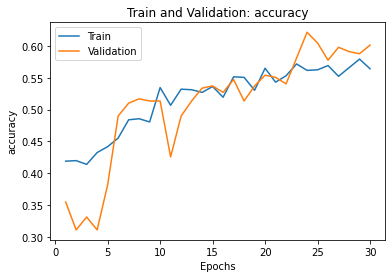

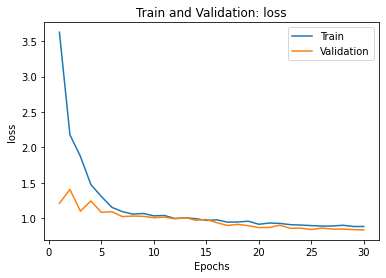

In [ ]:
# Plotting Accuracy.
plot_metric(history, "accuracy", val=True)

# Plotting Losses.
plot_metric(history, "loss", val=True)

In [ ]:
# Save the model.
model.save(MODELS_PATH+"base_model_aug1.h5")

In [ ]:
model_trained = load_model(MODELS_PATH+"base_model_aug1.h5")

In [ ]:
# Uncomment If needed.
#test_predictions = model.predict(test_STG1_dataset, verbose=1) 
test_predictions = model_trained.predict(test_STG1_dataset, verbose=1)

16/16 [==============================] - 221s 14s/step


In [ ]:
test_true_values, test_predictions_values = get_test_values(test_predictions, 
                                                            "solution_stg1_release.csv", 
                                                            using_google_colab)

In [ ]:
clas_report = classification_report(test_true_values, test_predictions_values, 
                                    target_names=CLASS_NAMES, zero_division="warn")
print(clas_report)

              precision    recall  f1-score   support

      Type_1       0.00      0.00      0.00        87
      Type_2       0.59      0.71      0.65       265
      Type_3       0.57      0.69      0.63       160

    accuracy                           0.59       512
   macro avg       0.39      0.47      0.43       512
weighted avg       0.49      0.59      0.53       512



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


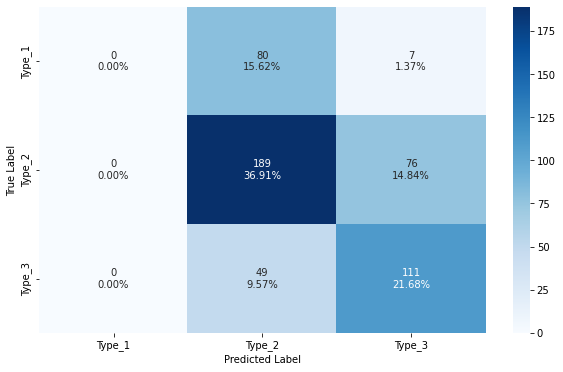

In [ ]:
conf_matrix = confusion_matrix(test_true_values, test_predictions_values)
plot_confusion_matrix(conf_matrix, CLASS_NAMES, 
                      xlabel="Predicted Label", ylabel="True Label") 

In [ ]:
# predicting the labels for test Stage 1 and 2 (4018 images).

# Uncomment If needed.
#test_predictions = model.predict(test_dataset_all, verbose=1)
test_predictions = model_trained.predict(test_dataset_all, verbose=1)

126/126 [==============================] - 873s 7s/step


In [ ]:
# Creating the csv for the model predictions, this is one the CSV files  
# that will be submitted to kaggle.
create_csv("base_model_aug1.csv", test_predictions, header, test_imgs_all, CSV_FOLDER)

csv file was created and saved successfully.


#### 2.2 Transfer Learning Models
All Transfer Learning models will use Data augmentation.

##### 2.2.1 EfficientNetV2S

In [12]:
# The Datasets will be recreated since EfficientNetV2S 
# expects inputs in rnage of [-1, 1].

# Train and Validation Dataset.
train_dataset, val_dataset = get_test_vald_ds(TRAIN_PATH, BATCH_SIZE, IMAGE_SIZE,
                                              normalise=True, norm_scale="mone_one")

# Test Datasets.
test_STG1_dataset = create_test_dataset(test_imgs_stg1, method="bicubic", 
                                        img_size=IMAGE_SIZE, batch_size=BATCH_SIZE, 
                                        normalise=True, norm_scale="mone_one")
test_STG2_dataset = create_test_dataset(test_imgs_stg2, method="bicubic", 
                                        img_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                                        normalise=True, norm_scale="mone_one")
test_dataset_all  = test_STG1_dataset.concatenate(test_STG2_dataset)

Found 1480 files belonging to 3 classes.
Using 1184 files for training.
Found 1480 files belonging to 3 classes.
Using 296 files for validation.


In [15]:
# Augment Train Dataset.
train_dataset = get_aug_dataset(train_dataset, data_aug)

In [16]:
pretrained_model = tf.keras.applications.EfficientNetV2S(input_shape=(256, 256, 3), 
                                                         include_top=False, weights="imagenet",
                                                         include_preprocessing=False)
pretrained_model.trainable = False

In [17]:
# Creating The Transfer Learning Model
model = Sequential([
    pretrained_model, 
    GlobalAveragePooling2D(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation="softmax")
])

In [18]:
model.compile(optimizer="adam",
              loss = "categorical_crossentropy",
              metrics=["accuracy"])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 8, 8, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)              

In [20]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=my_callbacks)

Epoch 1/30
37/37 [==============================] - 144s 3s/step - loss: 1.0398 - accuracy: 0.4890 - val_loss: 0.9563 - val_accuracy: 0.5338
Epoch 2/30
37/37 [==============================] - 14s 361ms/step - loss: 0.9699 - accuracy: 0.5405 - val_loss: 0.9548 - val_accuracy: 0.5405
Epoch 3/30
37/37 [==============================] - 14s 358ms/step - loss: 0.9266 - accuracy: 0.5600 - val_loss: 0.9376 - val_accuracy: 0.5439
Epoch 4/30
37/37 [==============================] - 14s 372ms/step - loss: 0.9138 - accuracy: 0.5676 - val_loss: 0.9427 - val_accuracy: 0.5743
Epoch 5/30
37/37 [==============================] - 14s 363ms/step - loss: 0.8914 - accuracy: 0.5760 - val_loss: 0.9377 - val_accuracy: 0.5642
Epoch 6/30
37/37 [==============================] - 13s 353ms/step - loss: 0.9197 - accuracy: 0.5642 - val_loss: 0.9550 - val_accuracy: 0.5405
Epoch 7/30
37/37 [==============================] - 13s 349ms/step - loss: 0.8873 - accuracy: 0.5819 - val_loss: 0.9269 - val_accuracy: 0.5405
E

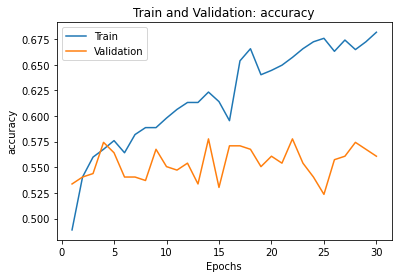

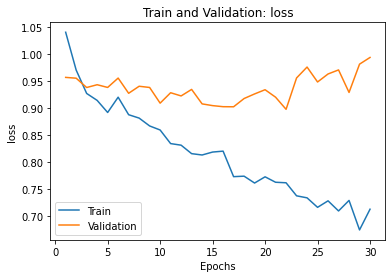

In [21]:
# Plotting Accuracy.
plot_metric(history, "accuracy", val=True)

# Plotting Losses.
plot_metric(history, "loss", val=True)

In [27]:
# Save the model.
model.save(MODELS_PATH+"EfficientNetV2S_model.h5")

In [ ]:
model_trained = load_model(MODELS_PATH+"EfficientNetV2S_model.h5")

In [22]:
# Uncomment If needed.
#test_predictions = model.predict(test_STG1_dataset, verbose=1) 
test_predictions = model_trained.predict(test_STG1_dataset, verbose=1)

16/16 [==============================] - 42s 2s/step


In [ ]:
test_true_values, test_predictions_values = get_test_values(test_predictions, 
                                                            "solution_stg1_release.csv", 
                                                            using_google_colab)

In [24]:
clas_report = classification_report(test_true_values, test_predictions_values, 
                                    target_names=CLASS_NAMES, zero_division="warn")
print(clas_report)

              precision    recall  f1-score   support

      Type_1       0.45      0.21      0.28        87
      Type_2       0.56      0.87      0.68       265
      Type_3       0.69      0.26      0.37       160

    accuracy                           0.56       512
   macro avg       0.57      0.44      0.45       512
weighted avg       0.58      0.56      0.52       512



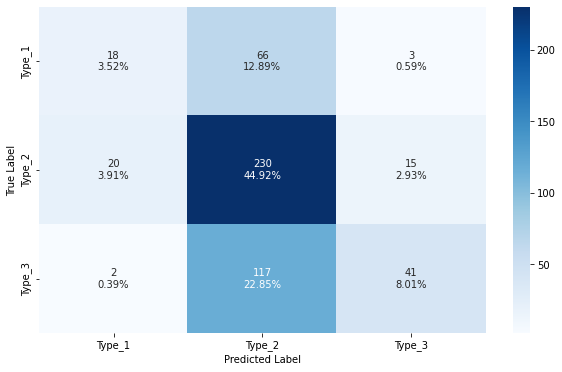

In [25]:
conf_matrix = confusion_matrix(test_true_values, test_predictions_values)
plot_confusion_matrix(conf_matrix, CLASS_NAMES, 
                      xlabel="Predicted Label", ylabel="True Label") 

In [26]:
# predicting the labels for test Stage 1 and 2 (4018 images).

# Uncomment If needed.
#test_predictions = model.predict(test_dataset_all, verbose=1)
test_predictions = model_trained.predict(test_dataset_all, verbose=1)

126/126 [==============================] - 815s 6s/step


In [28]:
# Creating the csv for the model predictions, this is one the CSV files  
# that will be submitted to kaggle.
create_csv("EfficientNetV2S_model.csv", test_predictions, header, test_imgs_all, CSV_FOLDER)

csv file was created and saved successfully.


##### 2.2.2 Xception

In [11]:
# The Datasets will be recreated since Xception. 
# expects inputs in rnage of [-1, 1] and image_size = (299, 299)

img_size = (299, 299)
# Train and Validation Dataset.
train_dataset, val_dataset = get_test_vald_ds(TRAIN_PATH, BATCH_SIZE, img_size,
                                              normalise=True, norm_scale="mone_one")

# Test Datasets.
test_STG1_dataset = create_test_dataset(test_imgs_stg1, method="bicubic", 
                                        img_size=img_size, batch_size=BATCH_SIZE, 
                                        normalise=True, norm_scale="mone_one")
test_STG2_dataset = create_test_dataset(test_imgs_stg2, method="bicubic", 
                                        img_size=img_size, batch_size=BATCH_SIZE,
                                        normalise=True, norm_scale="mone_one")
test_dataset_all  = test_STG1_dataset.concatenate(test_STG2_dataset)

Found 1480 files belonging to 3 classes.
Using 1184 files for training.
Found 1480 files belonging to 3 classes.
Using 296 files for validation.


In [15]:
# Augment Train Dataset.
train_dataset = get_aug_dataset(train_dataset, data_aug)

In [16]:
pretrained_model = tf.keras.applications.Xception(input_shape=(299, 299, 3), 
                                                  include_top=False, weights="imagenet")
pretrained_model.trainable = False

83697664/83683744 [==============================] - 1s 0us/step


In [17]:
# Creating The Transfer Learning Model
model = Sequential([
    pretrained_model, 
    GlobalAveragePooling2D(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation="softmax")
])

In [18]:
model.compile(optimizer="adam",
              loss = "categorical_crossentropy",
              metrics=["accuracy"])

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                      

In [20]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=my_callbacks)

Epoch 1/30
37/37 [==============================] - 400s 9s/step - loss: 1.0794 - accuracy: 0.4755 - val_loss: 1.0183 - val_accuracy: 0.5203
Epoch 2/30
37/37 [==============================] - 25s 668ms/step - loss: 1.0190 - accuracy: 0.5144 - val_loss: 0.9791 - val_accuracy: 0.5236
Epoch 3/30
37/37 [==============================] - 26s 704ms/step - loss: 0.9758 - accuracy: 0.5220 - val_loss: 0.9456 - val_accuracy: 0.5473
Epoch 4/30
37/37 [==============================] - 25s 668ms/step - loss: 0.9794 - accuracy: 0.5279 - val_loss: 0.9824 - val_accuracy: 0.5405
Epoch 5/30
37/37 [==============================] - 25s 663ms/step - loss: 0.9786 - accuracy: 0.5405 - val_loss: 0.9762 - val_accuracy: 0.5169
Epoch 6/30
37/37 [==============================] - 25s 673ms/step - loss: 0.9406 - accuracy: 0.5515 - val_loss: 0.9494 - val_accuracy: 0.5507
Epoch 7/30
37/37 [==============================] - 25s 672ms/step - loss: 0.9178 - accuracy: 0.5557 - val_loss: 0.9708 - val_accuracy: 0.5574
E

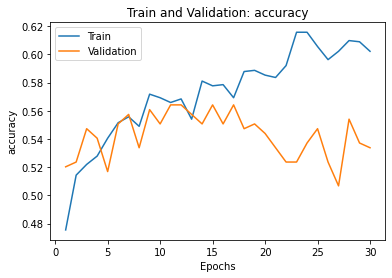

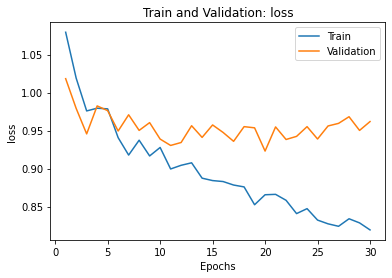

In [22]:
# Plotting Accuracy.
plot_metric(history, "accuracy", val=True)

# Plotting Losses.
plot_metric(history, "loss", val=True)

In [21]:
# Save the model.
model.save(MODELS_PATH+"Xception_model.h5")

In [ ]:
model_trained = load_model(MODELS_PATH+"Xception_model.h5")

In [23]:
# Uncomment If needed.
#test_predictions = model.predict(test_STG1_dataset, verbose=1)
test_predictions = model_trained.predict(test_STG1_dataset, verbose=1)

16/16 [==============================] - 271s 17s/step


In [ ]:
test_true_values, test_predictions_values = get_test_values(test_predictions, 
                                                            "solution_stg1_release.csv", 
                                                            using_google_colab)

In [25]:
clas_report = classification_report(test_true_values, test_predictions_values, 
                                    target_names=CLASS_NAMES, zero_division="warn")
print(clas_report)

              precision    recall  f1-score   support

      Type_1       0.50      0.08      0.14        87
      Type_2       0.55      0.94      0.69       265
      Type_3       0.71      0.18      0.29       160

    accuracy                           0.56       512
   macro avg       0.58      0.40      0.37       512
weighted avg       0.59      0.56      0.47       512



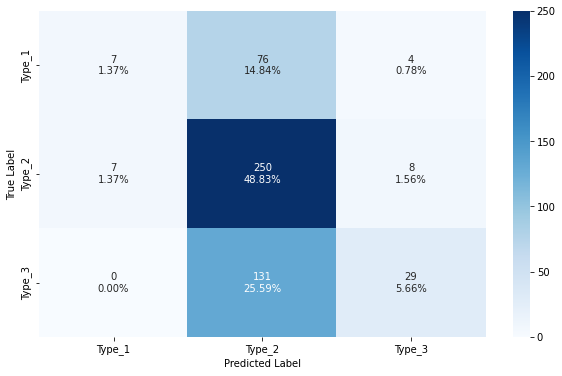

In [26]:
conf_matrix = confusion_matrix(test_true_values, test_predictions_values)
plot_confusion_matrix(conf_matrix, CLASS_NAMES, 
                      xlabel="Predicted Label", ylabel="True Label") 

In [27]:
# predicting the labels for test Stage 1 and 2 (4018 images).

# Uncomment If needed.
#test_predictions = model.predict(test_dataset_all, verbose=1)
test_predictions = model_trained.predict(test_dataset_all, verbose=1)

126/126 [==============================] - 1477s 12s/step


In [28]:
# Creating the csv for the model predictions, this is one the CSV files  
# that will be submitted to kaggle.
create_csv("Xception_model.csv", test_predictions, header, test_imgs_all, CSV_FOLDER)

csv file was created and saved successfully.
